<a href="https://colab.research.google.com/github/phyml4e/PINNs/blob/main/COMM_PINN/COMM_PINN_PLAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code include implementation of COMM-PINN method for von mieses plasticity model with nonlinear isotropic hardening law.

In [ ]:
pip install sciann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 29.6 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sciann as sn
from tensorflow import keras as k
import tensorflow as tf
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
from sciann.utils.math import diff
from numpy import gradient

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0] 



## **Material model and data/collocation point generation**

In [ ]:
# Material model based on return mapping alg.
def MM(ep, epP_i, xiP_i, prop):

  E  = prop[0]              
  h1 = prop[1]             
  h2 = prop[2]             
  y0 = prop[3]             

  sigT = E*(ep - epP_i)   #trial stress

  phi = abs(sigT) - (y0 + h1 * (1 - math.exp(-h2 * xiP_i)))

  if phi < 0:    #elastic step
    epP  = epP_i
    xiP  = xiP_i
    str0 = sigT
    tngMM = k0
    #print('yes no')
  
  else:
    epP  = epP_i
    xiP  = xiP_i
    str0 = sigT

    rp      = np.zeros([2,1])
    rp[0,0] = epP - epP_i - (xiP - xiP_i) * np.sign(str0)       #evol.
    rp[1,0] = abs(str0) - (y0 + h1 * (1 - math.exp(-h2 * xiP))) #yield 

    while np.linalg.norm(rp) > 10**(-5):
      Kp = np.zeros([2,2])
      Kp[0,0] = 1
      Kp[0,1] = -np.sign(str0)
      Kp[1,0] = -np.sign(str0)*E
      Kp[1,1] = -h1 * h2 * (math.exp(-h2 * xiP))

      Dsol = np.linalg.lstsq(-Kp, rp)[0]
      epP  = epP + Dsol[0,0]
      xiP  = xiP + Dsol[1,0]
      str0 = E*(ep - epP)

      rp[0,0] = epP - epP_i - (xiP - xiP_i) * np.sign(str0)
      rp[1,0] = abs(str0) - (y0 + h1 * (1 - math.exp(-h2 * xiP)))

    tngMM = k0*(1 - k0/(k0 + h1*h2*np.exp(-h2*xiP) ))

    if xiP < xiP_i:
      print('yes')
      xiP = xiP_i

  ene = 0.5*E*(ep - epP)**2 + h1*(xiP + (math.exp(-h2 * xiP)-1)/h2)

  return str0, epP, xiP, ene, tngMM

In [ ]:
# Generation of collocation points

# Material Parameters
k0   = 3.0         # Initial stiffness
h1   = 0.4         # Plas hardening parameter 1
h2   = 10.0        # Plas hardening parameter 2
y0   = 0.6         # Plas onset
prop = [k0, h1, h2, y0]
       
step = 0.01 
endg = 1
n    = 0

ps = np.array(np.arange(-0.0, 1.0 + step, step))
pp = np.array(np.arange(-0.0, 1.0 + step, step))
px = np.array(np.arange(0.0, 2 + step, step))

row = len(ps)*len(px)*len(pp)
INe  = np.zeros((row,3))

for i in range(len(ps)):                           
    for j in range(len(pp)):
        for k in range(len(px)):
            INe[n,0] = ps[i]
            INe[n,1] = pp[j]
            if px[k] >= pp[j]: 
               INe[n,2] = px[k]
               n += 1

IN  = np.zeros((n,3))
n = 0
for i in range(len(ps)):                           
    for j in range(len(pp)):
        for k in range(len(px)):
            IN[n,0] = ps[i]
            IN[n,1] = pp[j]
            if px[k] >= pp[j]: 
               IN[n,2] = px[k]
               n += 1


[-0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99  1.  ]
1540351
1540351


# **Training**

In [ ]:
#Designinh the network
dtype     = 'float32' 
n_of_n    = 5*[80]        # Number of neurons (layers*[neurons])                     
act       = 'Relu'        # AF "tanh", "softplus", "Relu", "sigmoid", "softmax"      
Epochs    = 20            # Number of epochs                                                                                
batch     = 50000         # Batch size  
LR        = 0.0001        # Learning rate 0.01  
Optimizer ='adam'         # such as 'scipy-l-BFGS-B' , 'SGD'

x1 = sn.Variable('x1', dtype=dtype)
x2 = sn.Variable('x2', dtype=dtype)
x3 = sn.Variable('x3', dtype=dtype)

y2 = sn.Functional('y2',[x1, x2, x3], n_of_n, act)
y3 = sn.Functional('y3',[x1, x2, x3], n_of_n, act)

dy2dx1 = diff(y2,x1) 

#Splitting the data into inputs and outputs
x1_1 = IN[:,0]       # Strain    
x2_1 = IN[:,1]       # plastic strain variable @ n
x3_1 = IN[:,2]       # plastic hardening variable @ n


In [ ]:
#Defining the physical constraints
kpt = 100.0                   #penalty term                                      
kpu = 100.0                   #penalty term                                        
kpe = 10
kpy = 1.0                     #penalty term                                    
kpd = 10.0                    #penalty term                                     
kpx = 100.0                   #penalty term                                        

phi    = sn.abs(k0*(x1-y2)) - (y0 + h1*(1 - sn.exp(-h2*y3))) # yield function:  sigT = E*(ep - epP_i)  AND phi = abs(sigT) - (y0 + h1 * (1 - math.exp(-h2 * xiP_i)))
phi_o  = sn.abs(k0*(x1-x2)) - (y0 + h1*(1 - sn.exp(-h2*x3)))

#physical constraints 
#R=1.0
#const1 = kpt*(y2-x2)*sn.relu(R*(-phi_o))                                  # unload ep_p
#const2 = kpu*(y3-x3)*sn.relu(R*(-phi_o))                                  # unload xip
##const3 = kpe*( y2-x2 - (y3-x3)*np.sign(k0*(x1-y2)) )*sn.relu(R*(phi_o))  # evolution eq.   rp[0,0] = epP - epP_i - (xiP - xiP_i) * np.sign(str0)
#const3 = kpe*( y2-x2 - (y3-x3)*sn.sigmoid(500*(x1-y2)) )*sn.relu(R*(phi_o)) 
#const4 = kpy*phi*sn.relu(R*(phi_o))                                       # yield function  rp[1,0] = abs(str0) - (y0 + h1 * (1 - math.exp(-h2 * xiP)))  
#const5 = kpd*(1.0)*sn.relu(R*(phi))                                       # KKT 1
#const6 = kpx*(1.0)*sn.relu(R*(x3-y3))                                     # KKT 2, growing xip    

R = 300 
const1 = kpt*(y2-x2)*sn.sigmoid(R*(-phi_o))*(-phi_o)               
const2 = kpu*(y3-x3)*sn.sigmoid(R*(-phi_o))*(-phi_o)
const3 = kpe*( y2-x2 - (y3-x3)*sn.sigmoid(R*(x1-y2)) )*sn.sigmoid(R*(phi_o))*(phi_o)
const4 = kpy*phi*sn.sigmoid(R*(phi_o))*(phi_o)   
const5 = kpd*(phi)*sn.sigmoid(R*(phi))*(phi)
const6 = kpx*(1.0)*sn.sigmoid(R*(x3-y3))*(x3-y3)               
                   

In [ ]:
#Defining the model
model = sn.SciModel([x1, x2, x3],[const1, const2, const3, const4, const5, const6], loss_func="mse", optimizer = Optimizer)

#Defining the inputs and outputs
x_data = [x1_1, x2_1, x3_1]
y_data = ['zeros', 'zeros', 'zeros', 'zeros', 'zeros', 'zeros']


In [ ]:
ADAPTIVE_WEIGHTS = {'method': 'GN', 'freq': 100, 'use_score': True, 'alpha': 1.0}

In [ ]:
#Fitting the model
history1 = model.train(x_data, y_data, learning_rate=LR, epochs=Epochs, batch_size=batch,verbose=-1)#, **{'adaptive_weights': ADAPTIVE_WEIGHTS})



Total samples: 1540351 
Batch size: 50000 
Total batches: 31 

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


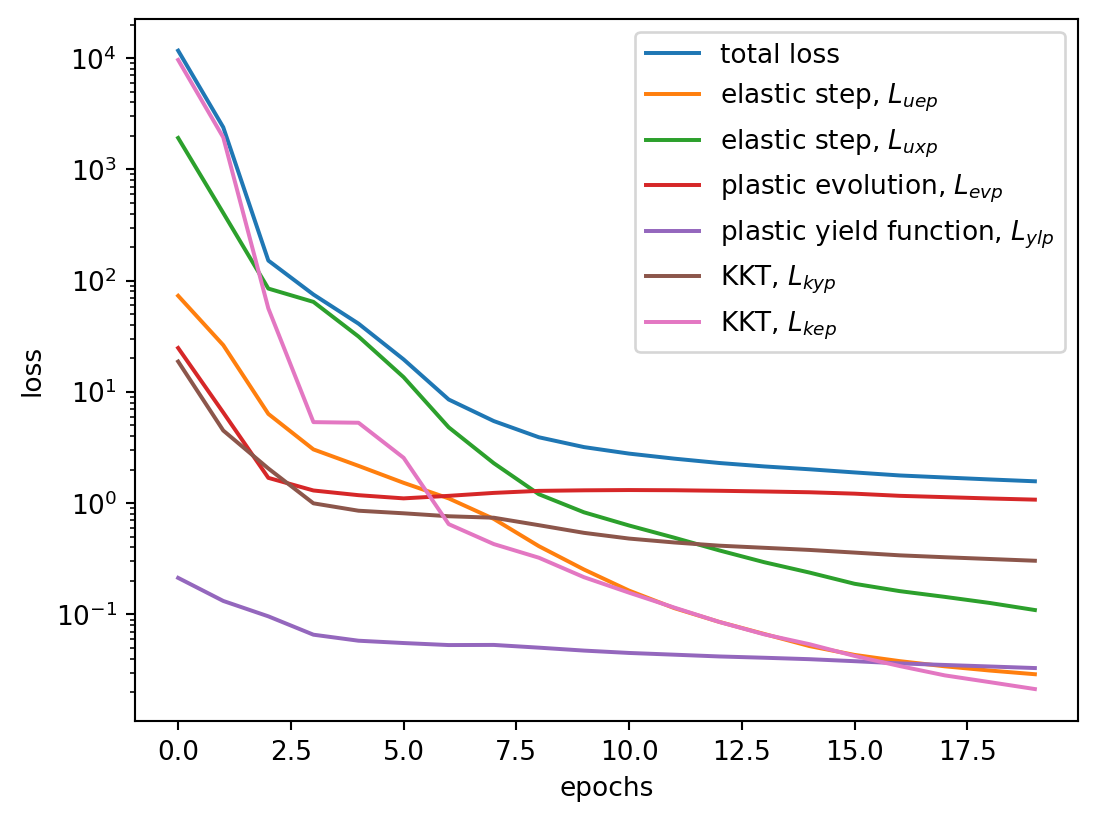

In [ ]:
loss_name = ['total loss','elastic step, $L_{uep}$','elastic step, $L_{uxp}$', 'plastic evolution, $L_{evp}$','plastic yield function, $L_{ylp}$', 'KKT, $L_{kyp}$', 'KKT, $L_{kep}$']

fig = plt.figure(dpi = 190)
itter = 0 
for word, loss in history1.history.items():
        if word.endswith("loss"):
            plt.semilogy(np.array(loss), label=loss_name[itter])
            itter+=1
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.pdf')




# **POST PROCESS**
 

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


<Figure size 640x480 with 0 Axes>

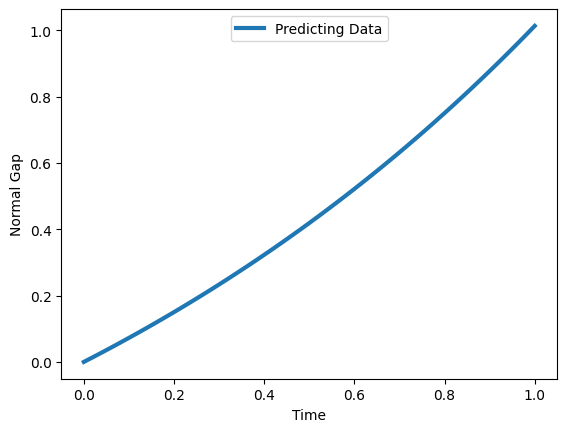

In [ ]:
#Defining a new loading path for prediction
numt = 51
numtl = numt

t2    = np.linspace(0, 1, numtl)                 # Time
#Ga    = 1.0*abs(t2*np.sin(3.1415*2*t2)) 
Ga    = 0.5*abs(t2*np.sin(3.1415*2*t2)) + 0.5*(np.sin(3.1415*1*t2))      
#Ga    = 1.0*t2**3   
#Ga    = 1.0*abs(np.sin(3.1415*1*t2))          

T = np.linspace(0, 1, numt)
plt.figure()
fig = plt.figure(dpi = 100)

plt.plot(t2, Ga, linewidth=3, label = 'Predicting Data')
plt.legend(loc = "upper center")
plt.xlabel("Time")
plt.ylabel("Normal Gap")
plt.show()


<ipython-input-3-691b4cf6e72c>:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Dsol = np.linalg.lstsq(-Kp, rp)[0]


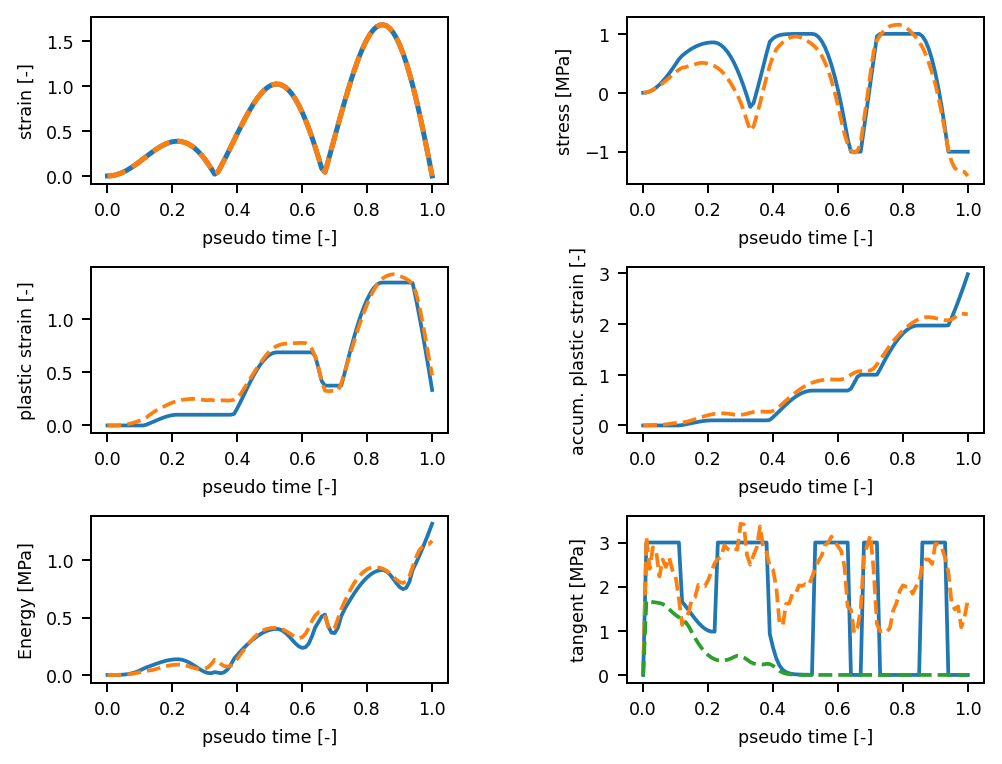

In [ ]:
# loop over loading path material model
#%%timeit
Dmg   = np.zeros(len(Ga))            
Xid   = np.zeros(len(Ga))          
Tra   = np.zeros(len(Ga))
Ene   = np.zeros(len(Ga))
tngMM = np.zeros(len(Ga))

for k in range(len(Ga)-1):
    Tra[k+1],Dmg[k+1],Xid[k+1],Ene[k+1],tngMM[k+1] = MM(Ga[k+1],Dmg[k],Xid[k],prop)
    
# loop over loading path NN
#%%timeit
x1_NN = Ga 
x1_NN = x1_NN.reshape(-1,1)
x2_NN = np.zeros_like(x1_NN)
x3_NN = np.zeros_like(x1_NN)
trc_d = np.zeros_like(x1_NN)
trc_N = np.zeros_like(x1_NN)
der   = np.zeros_like(x1_NN)
tngNN = np.zeros_like(x1_NN)
tngNNa = np.zeros_like(x1_NN)
eneNN = np.zeros_like(x1_NN)

for k in range(len(Ga)-1):
    #trc_N[k+1] = y1.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    x2_NN[k+1] = y2.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    x3_NN[k+1] = y3.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    trc_d[k+1] = k0*(x1_NN[k+1] - x2_NN[k+1])
    der[k+1]   = dy2dx1.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    tngNN[k+1] = k0*(1.0 - der[k+1])
    tngNNa[k+1] = k0*(1 - k0/(k0 + h1*h2*np.exp(-h2*x3_NN[k+1]) ))
    eneNN[k+1] = 0.5*k0*(x1_NN[k+1] - x2_NN[k+1])**2 + h1*(x3_NN[k+1] + (math.exp(-h2 * x3_NN[k+1])-1)/h2)


######################## plot 
fig = plt.figure(dpi = 180)
plt.rcParams['font.size'] = '7'
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(3, 2, 1)

plt.plot(t2, Ga, linewidth=2)
plt.plot(t2, Ga, '--', linewidth=2)
plt.xlabel("pseudo time [-]")
plt.ylabel("strain [-]")

ax = fig.add_subplot(3, 2, 2)
ax.plot(t2, Tra)
ax.plot(t2, trc_d, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("stress [MPa]")


ax = fig.add_subplot(3, 2, 3)
ax.plot(t2, Dmg, label='MM outcome')                       
ax.plot(t2, x2_NN, '--', label = "NN prediction")
plt.xlabel("pseudo time [-]")
plt.ylabel("plastic strain [-]")

ax = fig.add_subplot(3, 2, 4)
ax.plot(t2, Xid)
ax.plot(t2, x3_NN, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("accum. plastic strain [-]")

ax = fig.add_subplot(3, 2, 5)
ax.plot(t2, Ene)
ax.plot(t2, eneNN, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("Energy [MPa]")

ax = fig.add_subplot(3, 2, 6)
ax.plot(t2, tngMM)
ax.plot(t2, tngNN, '--')
ax.plot(t2, tngNNa, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("tangent [MPa]")

plt.savefig('compare_pl_tot.pdf')
    